In [2]:
import os
import numpy as np
from tensorflow.keras.models import load_model
from GPUtil import getFirstAvailable
from models import MODELS
import nibabel as nib

from matplotlib import pyplot as plt

from scipy.spatial.transform import Rotation

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"] = str(getFirstAvailable(order="load", maxLoad=0.1, maxMemory=0.1)[0])

In [4]:
#model_path = "../models/Entrack/conditional/2019-11-04-21:55:21/model_T=0.0202.h5"
model_path = "../models/Entrack/conditional/2019-11-13/22:24:08/model_T=0.0196.h5"
model_name = model_path.split("/")[2]

In [5]:
model = load_model(model_path,
                   custom_objects=MODELS[model_name].custom_objects,
                   compile=False)

In [6]:
dwi_img = nib.load("../subjects/992774/fod_norm.nii.gz")
dwi = dwi_img.get_data()

In [99]:
# Strong unidirectional signal (left-right)
vox_lr = dwi[72,91,74,:]

# Strong unidirectional signal (superior-inferior)
vox_si = dwi[87,85,84,:]
vox_si_tilted = dwi[86,85,82,:]

# Strong unidirectional signal (anterior-posterior)
vox_ap = dwi[76,108,78,:]

# Voxel outside of white matter (but inside of brain) with low signal amplitude, and no clear direction
vox_no_diff1 = dwi[48, 130, 50, :] # small ventricle
vox_no_diff2 = dwi[70, 112, 65, :] # large ventricle
vox_no_diff3 = dwi[18, 91, 39, :] # outside of brain

# Clear 90° crossing of two directions
vox_cross = dwi[90, 99, 81, :]

In [50]:
def make_uniform_block(vox, knockout=None):
    block = vox * np.ones([3,3,3,15])
    
    if knockout is None:
        return block
    else:
        idx = np.unravel_index(knockout, (3,3,3))
        block[idx[0],idx[1],idx[2]] = vox_no_diff3 # instead of 0
        return block

In [51]:
def place_vox(vox, i):
    #block = np.zeros([3,3,3,15])
    block = make_uniform_block(vox_no_diff3)
    idx = np.unravel_index(i, (3,3,3))
    block[idx[0],idx[1],idx[2]] = vox
    return block

In [57]:
def make_input_vec(vin, d):
    dnorm = np.linalg.norm(d) + 10**-2
    du = (d / dnorm).flatten()
    return np.hstack([vin, du, dnorm]).reshape(1,-1)

In [11]:
def predict(model, vin, d, return_fvm=False):
    input_vec = make_input_vec(vin, d)
    fvm, kappa = model(input_vec)
    if return_fvm:
        return fvm.mean_direction.numpy()[0], kappa.numpy()[0], fvm
    else:
        return fvm.mean_direction.numpy()[0], kappa.numpy()[0]

In [12]:
def plot_rot(vin, d, rot_dir):
    angles = np.linspace(0, np.pi, 15)
    k = []
    dev = []
    plt.figure(dpi=100)
    for angle in angles:
        rot = Rotation.from_rotvec(np.array(rot_dir) * angle)
        vrot = rot.apply(vin)
        mu, kappa = predict(model, vrot, d)
        k.append(kappa)
        dev.append(np.arccos(np.sum(mu*vrot)) / np.pi *180)
    fig, ax1 =plt.subplots(dpi=100)
    ax1.plot(angles/np.pi*180, k, "-o", color="tab:blue")
    ax1.set_xlabel("angle (°)")
    ax1.set_ylabel(r"$\kappa$", color="tab:blue")
    ax1.tick_params(axis='y', labelcolor="tab:blue")
    ax1.set_ylim(47.5,51)
    
    ax2 = ax1.twinx()
    ax2.plot(angles/np.pi*180, dev, "-o", color="tab:orange")
    ax2.set_ylabel(r"deviation $\mu^Tv_{in}$ (°)", color="tab:orange")
    ax2.tick_params(axis='y', labelcolor="tab:orange")
    ax2.set_ylim(0,25)
    fig.tight_layout() 

# Zero diffusion data, no incoming direction
This is a bit artifical, because the model is per definition conditional, i.e. it always expects an incoming direction in the input.

In [16]:
vin = [0,0,0]
d = np.zeros([3,3,3,15])
predict(model, vin, d)

(array([ 0.25093213,  0.8977283 , -0.36210066], dtype=float32), 0.001)

# Zero diffusion data with incoming direction
We can observe, that in the absence of a diffusion signal, the output direction is strongly influenced by the incoming direction. Moreover, the certainty is considerably higher than without vin.

In [17]:
vin = [1,0,0]
d = np.zeros([3,3,3,15])
predict(model, vin, d)

(array([ 0.99697804,  0.05699175, -0.05278939], dtype=float32), 48.303856)

# Rotate vin with zero diffusion data
Here we rotate vin around the z-axis (green) and observe how the ouput direction (red) follows along, and how its uncertainty changes (length).

WEIRD: We would expect a more constant kappa, and also lower.

<Figure size 600x400 with 0 Axes>

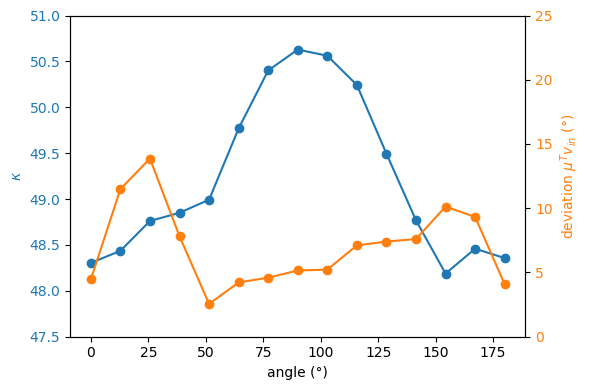

In [18]:
plot_rot(vin=[1,0,0], d=np.zeros([3,3,3,15]), rot_dir=[0,0,1]);

# Rotate vin with single clear direction
The block consists entirely of a single strong direction, and now we rotate vin out-of-plane (at angle=0, vin is perpendicular to the main direction, at angle=90 it points in the same direction)

<Figure size 600x400 with 0 Axes>

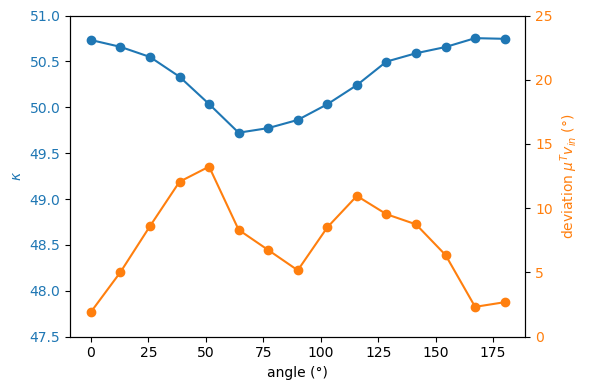

In [19]:
plot_rot(vin=[0,0,1], d=make_uniform_block(vox_si), rot_dir=[0,1,0])

<Figure size 600x400 with 0 Axes>

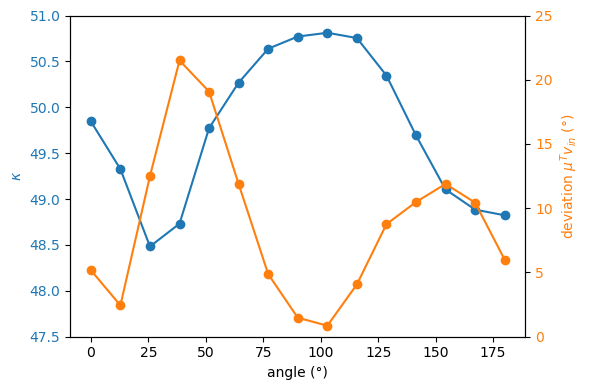

In [71]:
plot_rot(vin=[1,0,0], d=make_uniform_block(vox_si), rot_dir=[0,0,1])

<Figure size 600x400 with 0 Axes>

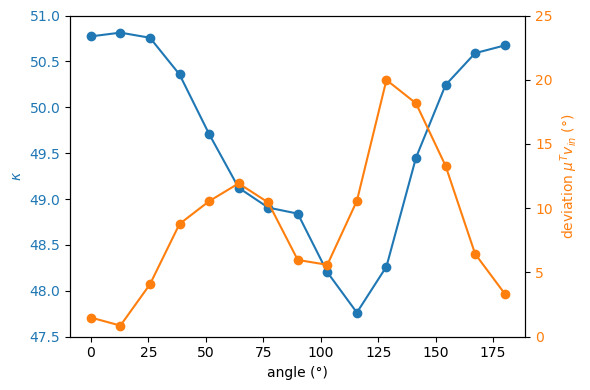

In [39]:
plot_rot(vin=[0,1,0], d=make_uniform_block(vox_si), rot_dir=[0,0,1])

# Crossing
We rotate vin, while the diffusion data is a clear 90° crossing. We expect a double-peak behavior of the uncertainty, corresponding to the presence of two main directions

<Figure size 600x400 with 0 Axes>

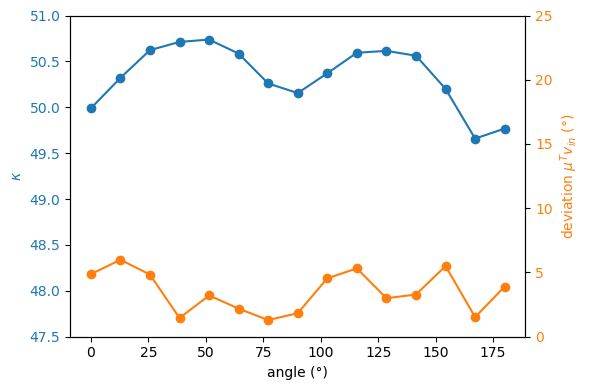

In [21]:
plot_rot(vin=[1,0,0], d=make_uniform_block(vox_cross), rot_dir=[0,1,0])

# Signal Strength
Now we keep vin and the diffusion direction fixed, and vary only the magnitude of the diffusion signal

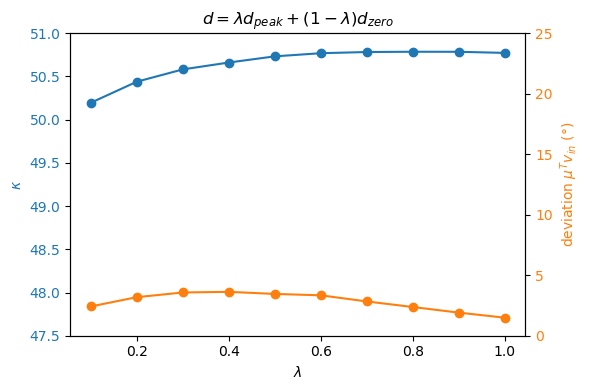

In [22]:
vin = [0,1,0]
d = make_uniform_block(vox_si)

k = []
dev = []
weights = np.linspace(0.1, 1, 10)
for w in weights:
    mu, kappa = predict(model, vin, w*d)
    k.append(kappa)
    dev.append(np.arccos(np.sum(mu*vin)) / np.pi *180)

fig, ax1 =plt.subplots(dpi=100)
ax1.plot(weights, k, "-o", color="tab:blue")
ax1.set_xlabel(r"$\lambda$")
ax1.set_ylabel(r"$\kappa$", color="tab:blue")
ax1.tick_params(axis='y', labelcolor="tab:blue")
ax1.set_ylim(47.5,51)
ax1.set_title(r"$d=\lambda d_{peak} + (1-\lambda)d_{zero}$");

ax2 = ax1.twinx()
ax2.plot(weights, dev, "-o", color="tab:orange")
ax2.set_ylabel(r"deviation $\mu^Tv_{in}$ (°)", color="tab:orange")
ax2.tick_params(axis='y', labelcolor="tab:orange")
ax2.set_ylim(0,25)
fig.tight_layout() 

# Interpolation between single direction and crossing
We interpolate between a single direction and a crossing, keeping vin fixed along the common main direction.
Apparently, a clear crossing still has higher certainty than a mixture of single and crossing.

<Figure size 600x400 with 0 Axes>

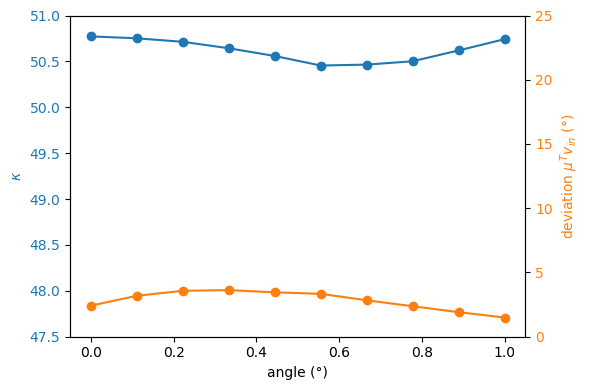

In [23]:
vin = [0,1,0]
d = make_uniform_block(vox_si)
dcross = make_uniform_block(vox_cross)

k = []
plt.figure(dpi=100)
weights = np.linspace(0, 1, 10)
for w in weights:
    _, kappa = predict(model, vin, (1-w)*d + w*dcross)
    k.append(kappa)
    
fig, ax1 =plt.subplots(dpi=100)
ax1.plot(weights, k, "-o", color="tab:blue")
ax1.set_xlabel("angle (°)")
ax1.set_ylabel(r"$\kappa$", color="tab:blue")
ax1.tick_params(axis='y', labelcolor="tab:blue")
ax1.set_ylim(47.5,51)

ax2 = ax1.twinx()
ax2.plot(weights, dev, "-o", color="tab:orange")
ax2.set_ylabel(r"deviation $\mu^Tv_{in}$ (°)", color="tab:orange")
ax2.tick_params(axis='y', labelcolor="tab:orange")
ax2.set_ylim(0,25)
fig.tight_layout() 

In [58]:
def closeness(i):
    dist = np.linalg.norm(np.array(np.unravel_index(i, (3,3,3))) - (1,1,1))
    if dist < 1:
        return "r"
    
    elif dist < np.sqrt(2):
        return "orange"
    
    elif dist < np.sqrt(3):
        return "g"
    else:
        return "b"

In [159]:
def aheadness(i):
    idx = np.array(np.unravel_index(i, (3,3,3)))
    if idx[0] == 2:
        return "r"
    
    elif idx[0] == 1:
        return "orange"
    
    elif idx[0] == 0:
        return "g"
    else:
        return "b"

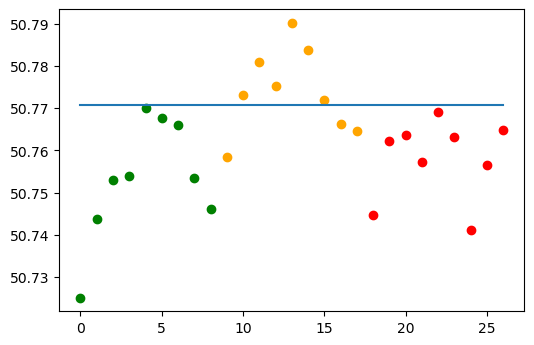

In [160]:
vin = [0,1,0]

plt.figure(dpi=100)
idx = np.arange(27)
for i in idx:
    d = make_uniform_block(vox_si, knockout=i)
    _, kappa = predict(model, vin, d)
    plt.plot(i, kappa, "o", color=aheadness(i))
d = make_uniform_block(vox_si)
_, kappa = predict(model, vin, d)
plt.plot([0,26],[kappa, kappa]);

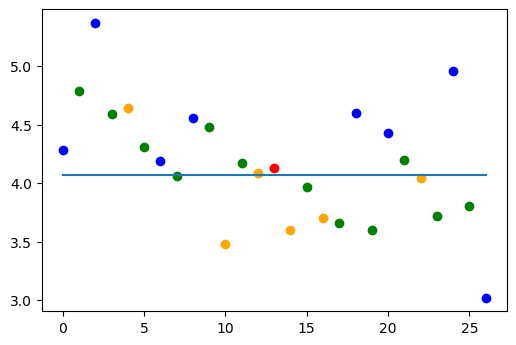

In [97]:
vin = [0,1,0]

plt.figure(dpi=100)
idx = np.arange(27)
for i in idx:
    d = make_uniform_block(vox_lr, knockout=i)
    mu, _ = predict(model, vin, d)
    dev = np.arccos(np.sum(mu*vin)) / np.pi *180
    plt.plot(i, dev, "o", color=closeness(i))
    
d = make_uniform_block(vox_lr)
mu, _ = predict(model, vin, d)
dev = np.arccos(np.sum(mu*vin)) / np.pi *180
plt.plot([0,26],[dev, dev]);

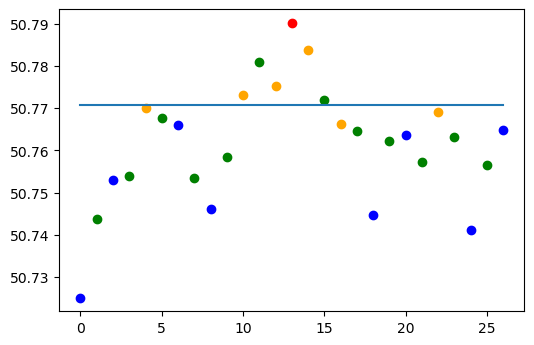

In [144]:
vin = [0,1,0]

plt.figure(dpi=100)
idx = np.arange(27)
for i in idx:
    d = make_uniform_block(vox_si, knockout=i)
    _, kappa = predict(model, vin, d)
    plt.plot(i, kappa, "o", color=closeness(i))
    
d = make_uniform_block(vox_si)
_, kappa = predict(model, vin, d)
plt.plot([0,26],[kappa, kappa]);

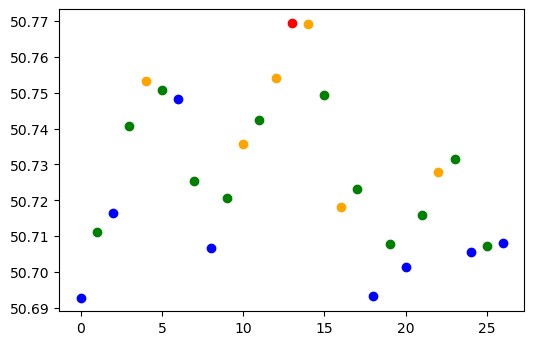

In [81]:
vin = [0,1,0]

plt.figure(dpi=100)
idx = np.arange(27)
for i in idx:
    kappa=0
    for vox in dwi[87-1:87+2,85-1:85+2,84-1:84+2,:].reshape(-1,15):
        d = make_uniform_block(vox, knockout=i)
        _, k = predict(model, vin, d)
        kappa += k / 27
        
    plt.plot(i, kappa, "o", color=closeness(i))

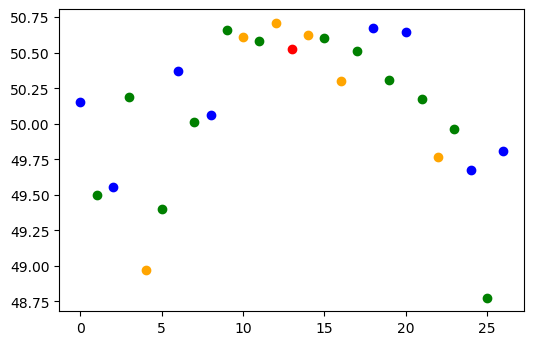

In [62]:
vin = [0,1,0]

plt.figure(dpi=100)
idx = np.arange(27)
for i in idx:
    d = place_vox(vox_lr, i)
    _, kappa = predict(model, vin, d)
    plt.plot(i, kappa, "o", color=closeness(i))

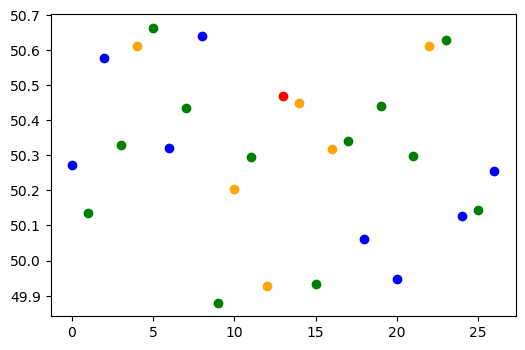

In [63]:
vin = [0,1,0]

plt.figure(dpi=100)
idx = np.arange(27)
for i in idx:
    d = place_vox(vox_ap, i)
    _, kappa = predict(model, vin, d)
    plt.plot(i, kappa, "o", color=closeness(i))

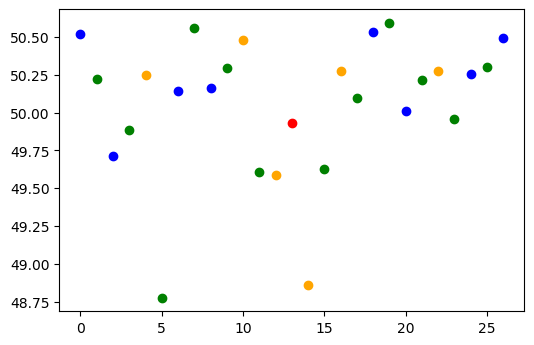

In [102]:
vin = [0,1,0]

plt.figure(dpi=100)
idx = np.arange(27)
for i in idx:
    d = place_vox(vox_si_tilted, i)
    _, kappa = predict(model, vin, d)
    plt.plot(i, kappa, "o", color=closeness(i))